In [1]:
import cv2
import numpy as np

# %matplotlib widget
import matplotlib.pyplot as plt

Ces étapes seront utilisées dans *deep_prediction.py* et *line_prediction.py*

# Le preprocessing

Ce sont toutes les étapes faites avant que les images soient données au modèle de prédiction. Que cela soit par le deep learning ou le hough lines.

Cf partie 4 du rapport

### Segmentation du code

 1. Étapes de preprocessing
 2. Création de la chaine de traitement
 3. Test sur une image

# Étapes de preprocessing

In [2]:
class CannyTrsf:
    """
    Apply a Gaussian blur to smooth the image 
    Do an edge detection from an RGB image
    """
    def __init__(self, blur_size=5):
        """
        Attribute initialization

        @param blur_size: the kernel size for gaussian blur
        """
        self.blur_size = (blur_size, blur_size)
    
    def __call__(self, image):
        """
        Apply the transformation

        @param image: a RGB OpenCV image
        @return: the edges of image
        """
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        blur = cv2.GaussianBlur(gray, self.blur_size, 0)
        canny = cv2.Canny(blur, 20, 100)
        return canny
  
    
class ROISelection:
    """
    Set to (0, 0, 0) each pixel outside the roi
    """
    def __init__(self, poly):
        """
        Attribute initialization

        @param poly: an array of coordinates for roi
        """
        self.poly = poly
        
    def __call__(self, image):
        """
        Apply the transformation

        @param image: a grayscale OpenCV image
        @return: the image with only roi
        """
        mask = np.zeros_like(image)
        cv2.fillPoly(mask, (self.poly,), 255)
        masked_image = cv2.bitwise_and(image, mask)
        return masked_image

    
class Resize():
    """
    Divide by 2 the image dimensions
    """
    def __call__(self, sample):
        """
        Apply the transformation

        @param image: a OpenCV image
        @return: the resized image
        """
        image = cv2.resize(sample, (0,0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
        return image
 
 
class Crop:
    """
    Remove pixels on the top and the right
    """
    def __call__(self, sample):
        """
        Apply the transformation

        @param image: a OpenCV image
        @return: the cropped image
        """
        width = sample.shape[1]
        return sample[45:, :width-5]
    
       
class Normalize():
    """
    Normalized the image with mean of 0 and std of 1
    """
    def __call__(self, sample):
        """
        Apply the transformation
        
        @param image: a grayscale OpenCV image
        @return: a Numpy array normalized image with dimension of (69, 223, 1)
        """
        image = sample
        norm_img = np.zeros(image.shape)
        norm_img = cv2.normalize(image, norm_img, 0, 1, cv2.NORM_MINMAX)
        norm_img = norm_img.reshape(69, 223, -1)
        
        return norm_img
  
        
class ToTensor:
    """
    Add the batch dimension in axis 0
    """
    def __call__(self, sample):
        """
        Apply the transformation
        
        @param image: a Numpy array of dimension (69, 223, 1)
        @return: a Numpy array of dimension (1, 69, 223, 1)
        """
        image = sample.reshape(-1, 69, 223, 1)
        return image

# Création de la chaine de traitement

In [3]:
class ProcessChain:
    """
    Create the preprocess pipeline before going in the CNN.
    Each element must be callable. 
    Take care about the dimension between the return and the argument for the next class.
    """
    def __init__(self):
        """
        Initialization of the preprocess pipeline, "line"
        """
        self.line = [
            CannyTrsf(),
            ROISelection(
                np.array([(0, 131), (0, 228), (450, 228), (450, 131), (300, 94), (150, 94)])
            ),
            Resize(),
            Crop(),
            Normalize(),
#             ToTensor()
        ]

    def transform(self, image):
        """
        Iterate through "line" and return the last item
        
        @param image: a OpenCV image of dimension (456, 228, 3)
        @return: a Numpy array of dimension (1, 69, 223, 1)
        """
        item = image
        for process in self.line:
            item = process(item)
        
        return item
    
    def transform_and_save(self, image):
        """
        Iterate through "line" keep all intermediate items
        and return the last one
        Used for debugging
        
        @param image: a OpenCV image of dimension (456, 228, 3)
        @return item: a Numpy array of dimension (1, 69, 223, 1)
        @return change_keeper: a list with each preprocess step
        """
        change_keeper = []
        item = image
        for process in self.line:
            item = process(item)
            change_keeper.append(item)
        
        return item, change_keeper

# Test sur une image

In [4]:
camera_image = cv2.imread("../data/images/shot.jpg")
print("shape:", camera_image.shape)

process = ProcessChain()
_, tracking = process.transform_and_save(camera_image)

shape: (228, 456, 3)


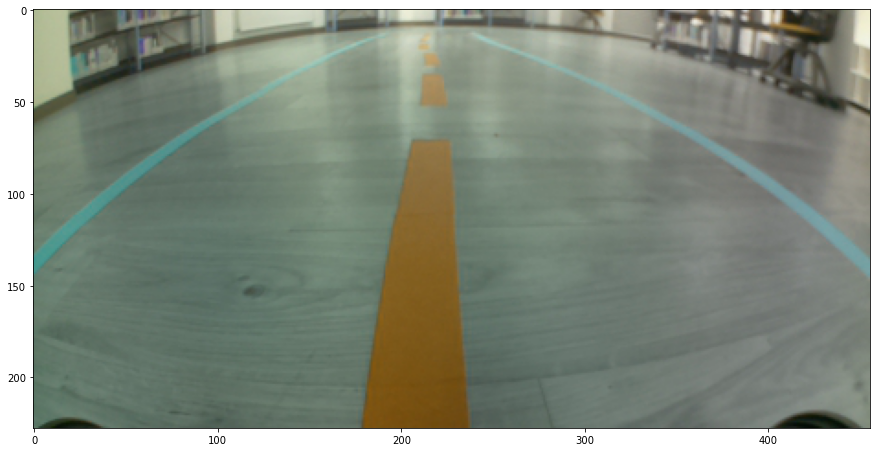

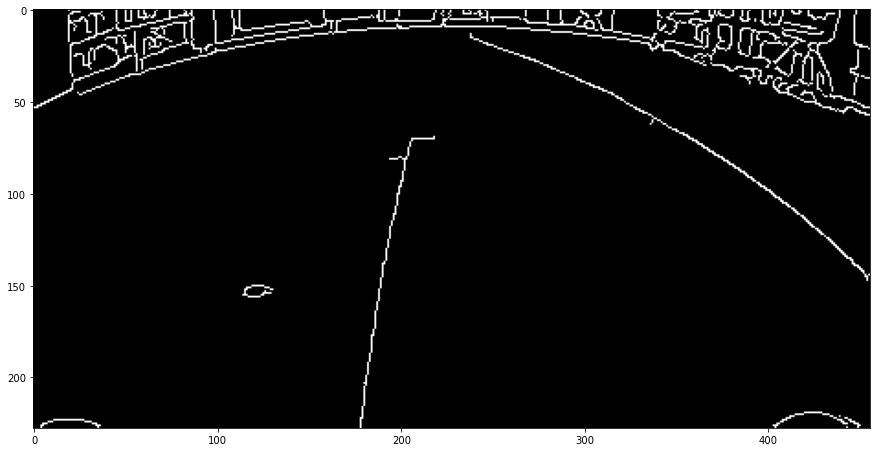

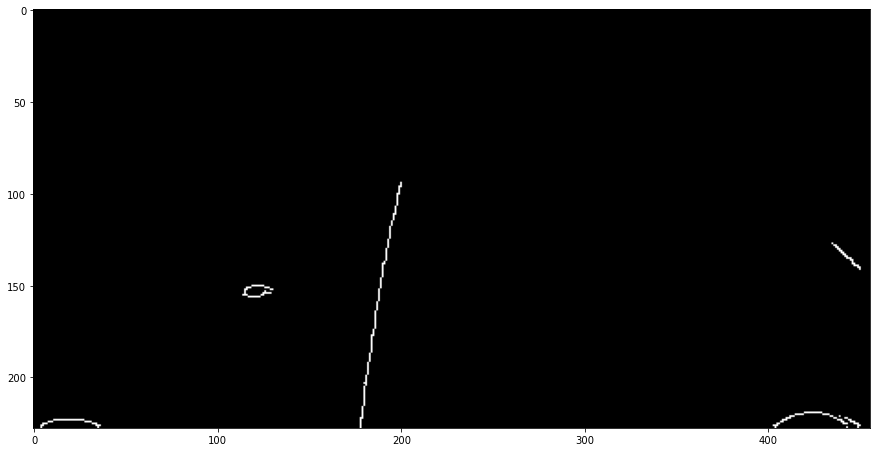

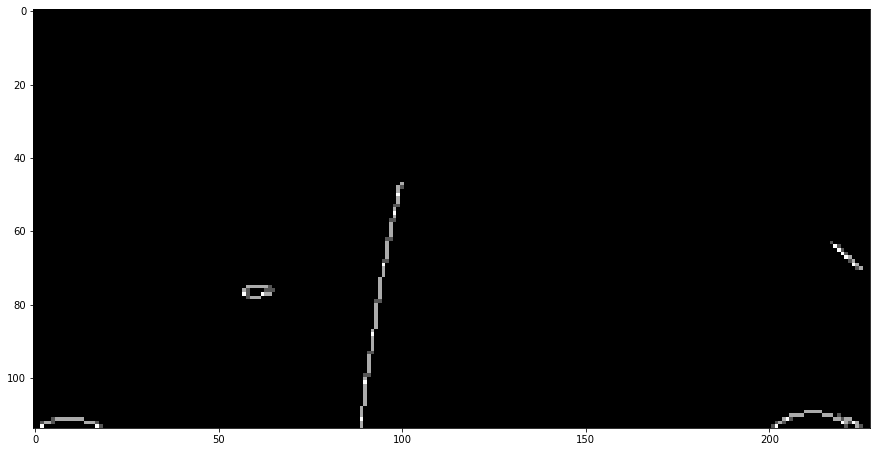

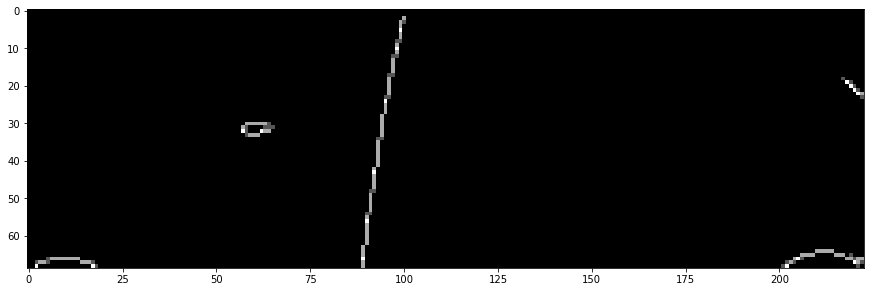

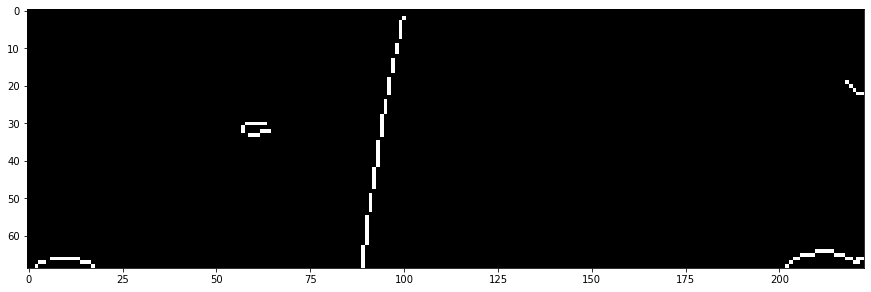

In [5]:
plt.figure(figsize=(15, 15))
plt.imshow(camera_image)
plt.show()

for image in tracking:
    plt.figure(figsize=(15, 15))
    plt.imshow(image, cmap="gray")
    plt.show()